<a href="https://colab.research.google.com/github/j0ngle/ASL_Classifier/blob/main/Pokemon_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using pokemon images collected from [here](https://www.kaggle.com/kvpratama/pokemon-images-dataset), I would like to *try* to generate new pokemon using a Deep Convolutional Generative Adversarial Network (DCGAN).

I don't anticipate this going well, but it'll be a good way to practice getting them set up with RBG images

Followed a [this](https://www.kaggle.com/jadeblue/dcgans-and-techniques-to-optimize-them) tutorial to learn the concepts. Code isn't 1:1

In [26]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Getting and processing the data

In [27]:
#Image Constants
IMG_SIZE = 64
PATH = '/content/drive/MyDrive/Summer 2021 AI Research Stuff/Colab Files/Resources/pokemon_jpg/pokemon_jpg/'

The output activation funtion for the generator is tanh, which outputs values from -1 to 1. As such, we need to normalize our images to satisfy this range

In [28]:
def process_image(img_path):
  #Convert Image to numpy array
  img = cv2.imread(img_path)

  #Resize the image
  img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)

  #Normalize image
  img = (img - 127.5) / 127.5
  #img = img / 255.

  return img.astype(np.float32)

def show_image(image):
  #Readjusted pixel values (convert from [-1, 1] to [0, 1]) 
  image_adjusted = (image * 127.5 + 127.5) / 255.
  plt.imshow(image_adjusted, cmap='binary')
  plt.axis('off')
  plt.show()

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((image * 127.5 + 127.5) / 255.)
        plt.axis("off")

In [29]:
images = []

for filename in os.listdir(PATH):
  if filename.endswith('jpg'):
    img = None
    img = process_image(PATH + filename)

    images.append(img)

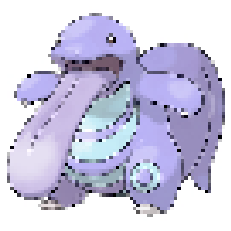

In [30]:
show_image(images[0])

# Creating the model

In [31]:
#Network constants
SAMPLE_SIZE = 800
BATCH_SIZE = 32
LEAKY_SLOPE = 0.2
DROPOUT = 0.4
CODINGS_SIZE = 128
SCALE = 16

WEIGHT_STD = 0.02
WEIGHT_MEAN = 0

tf.random.set_seed(42)
np.random.seed(42)

Converting Python list to Tensorflow dataset

(Might consider a random flip augmentation later. That'll be done through a map call on the dataset)

In [32]:
x_train = np.asarray(images)

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(800)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [33]:
scaled_size = IMG_SIZE // SCALE
weight_init = tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_STD, mean=WEIGHT_MEAN, seed=42)

Wrapping layers into functions so they are easier to update and visualize.

This was too messy

~~~
generator = keras.models.Sequential([
    keras.layers.Dense(scaled_size * scaled_size * 128, input_shape=(CODINGS_SIZE,)),
    keras.layers.Reshape([scaled_size, scaled_size, 128]),

    keras.layers.Conv2DTranspose(512, kernel_size=5, strides=1, padding='same', activation='relu', kernel_initializer=weight_init),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(DROPOUT),

    keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer=weight_init),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(DROPOUT),

    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer=weight_init),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer=weight_init),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer=weight_init),

    keras.layers.Dense(3, activation='tanh')
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=1, padding='same', activation=keras.layers.LeakyReLU(LEAKY_SLOPE), input_shape=[64, 64, 3], kernel_initializer=weight_init), 
    
    keras.layers.Dropout(DROPOUT),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(LEAKY_SLOPE), kernel_initializer=weight_init), 
    keras.layers.BatchNormalization(),

    keras.layers.Dropout(DROPOUT),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(LEAKY_SLOPE), kernel_initializer=weight_init),
    keras.layers.BatchNormalization(),

    keras.layers.Dropout(DROPOUT),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(LEAKY_SLOPE), kernel_initializer=weight_init), 
    keras.layers.BatchNormalization(),

    keras.layers.Dropout(DROPOUT),
    keras.layers.Conv2D(512, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(LEAKY_SLOPE), kernel_initializer=weight_init), 
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')     
])

gan = keras.models.Sequential([generator, discriminator])
~~~

In [34]:
def conv_transpose(model, out_channels, k_size, s_size, batch_normalize=True):
  model.add(keras.layers.Conv2DTranspose(out_channels, kernel_size=(k_size, k_size), 
                                         strides=(s_size, s_size), padding='same', 
                                         kernel_initializer=weight_init))
  if batch_normalize is True:
    model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.ReLU())

  return model

def conv(model, out_channels, k_size, s_size, batch_normalize=True):
  model.add(keras.layers.Conv2D(out_channels, kernel_size=(k_size, k_size), 
                                strides=(s_size, s_size), padding='same', 
                                kernel_initializer=weight_init))
  if batch_normalize is True:
    model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.LeakyReLU(LEAKY_SLOPE))

  return model

In [35]:
def generator():
  model = keras.models.Sequential()

  model.add(keras.layers.Dense(scaled_size * scaled_size * 128, input_shape=(CODINGS_SIZE,), kernel_initializer=weight_init))
  model.add(keras.layers.Reshape([scaled_size, scaled_size, 128]))
  
  model = conv_transpose(model, 512, k_size=5, s_size=1)
  model.add(keras.layers.Dropout(DROPOUT))

  model = conv_transpose(model, 256, k_size=5, s_size=2)
  model.add(keras.layers.Dropout(DROPOUT))

  model = conv_transpose(model, 128, k_size=5, s_size=2)
  model = conv_transpose(model, 64, k_size=5, s_size=2)
  model = conv_transpose(model, 32, k_size=5, s_size=2, batch_normalize=False)

  model.add(keras.layers.Dense(3, activation='tanh', kernel_initializer=weight_init))

  return model

def discriminator():
  model = keras.models.Sequential()

  model.add(keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), 
                              padding='same', activation=keras.layers.LeakyReLU(LEAKY_SLOPE), 
                              input_shape=[64, 64, 3], kernel_initializer=weight_init)) 

  model.add(keras.layers.Dropout(DROPOUT))
  model = conv(model, 64, k_size=5, s_size=2)

  model.add(keras.layers.Dropout(DROPOUT))
  model = conv(model, 128, k_size=5, s_size=2)

  model.add(keras.layers.Dropout(DROPOUT))
  model = conv(model, 256, k_size=5, s_size=2)

  model.add(keras.layers.Dropout(DROPOUT))
  model = conv(model, 512, k_size=5, s_size=2)

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  return model

In [36]:
generator = generator()
discriminator = discriminator()

gan = keras.models.Sequential([generator, discriminator])

In [37]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2048)              264192    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 4, 4, 512)         1638912   
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 256)        

In [38]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)      

In [39]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

Testing that the models were compiled correctly

The Generator should produce a black box since the weights were normalized to be relatively zero-centered

The Discriminator should predict the generated image with a probability of about 0.5 since it is untrained

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 64, 64, 3)
(1, 128) 0.039112236 0.91619134


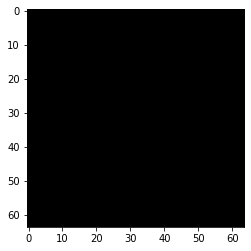

In [40]:
noise = tf.random.normal([1, CODINGS_SIZE])

generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)
print(noise.shape, tf.math.reduce_mean(noise).numpy(), tf.math.reduce_std(noise).numpy())

In [41]:
print(discriminator(generated_image))

tf.Tensor([[0.5000011]], shape=(1, 1), dtype=float32)


# Training the Model

**Label Smoothing** prevents the discriminator from being either over confident or underconfident in its predictions.

Essentially if the discriminator is too certain that there is a dog in a given image, the generator can exploit that and contiuously generate similar images, thus it'll stop improving.

This can be combatted by setting the

1. Negative Class labels to a range [0, 0.3]
2. Postitive Class labels to a range [0.7, 1]

**Instance Noise** adds a small amount of error to the labels, which tends to make the true and predicted distributions more spread out.

Instance Noise makes the learning process for the generator easier

ngl idk exactly how this algorithm works, but it does the above

In [42]:
def smooth_labels(y, label_type):
  if label_type is 'positive':
    return y - 0.3 + (np.random.random(y.shape) * 0.5)
  elif label_type is 'negative':
    return y + np.random.random(y.shape) * 0.3
  else:
    raise ValueError('Expected "positive" or "negative" for label_type. Recieved:', label_type)

def noisy_labels(y, p_flip):
  length = int(y.shape[0])

  num_labels = int(p_flip * length)

  i_flip = np.random.choice([i for i in range(length)], size=num_labels)

  op_list = []
  for i in range(length):
    if i in i_flip:
      op_list.append(tf.subtract(1, y[i]))
    else:
      op_list.append(y[i])

  outputs = tf.stack(op_list)
  return outputs

Defining Loss Functions

Uses Binary Crossentropy to calculate loss.

Discriminator loss: How well the discriminator was able to detect fake images

Generator loss: How well the generator was able to fool the discriminator. We apply positive (1) labels to all generated images to attempt to fool the discriminator

In [73]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output, apply_smoothing=True, apply_noise=True):
  real_output_mod = real_output
  fake_output_mod = fake_output

  if apply_noise:
    real_output_mod = noisy_labels(tf.ones_like(real_output_mod), 0.05)
    fake_output_mod = noisy_labels(tf.zeros_like(fake_output_mod), 0.05)
  
  if apply_smoothing:
    real_output_mod = smooth_labels(real_output_mod, 'positive')
    fake_output_mod = smooth_labels(fake_output_mod, 'negative')

  real_loss = cross_entropy(tf.ones_like(real_output_mod), real_output) #labels, outputs
  fake_loss = cross_entropy(tf.zeros_like(fake_output_mod), fake_output)

  return real_loss + fake_loss

def generator_loss(fake_output, apply_smoothing=True):
  real_output_mod = real_output
  fake_output_mod = fake_output

  if apply_smoothing:
    fake_output_mod = smooth_labels(fake_output_mod, 'negative')

  return cross_entropy(tf.ones_like(fake_output_mod), fake_output)

In [64]:
def plot_losses(G_loss, D_loss, G_loss_total, D_loss_total, epoch):
  plt.figure(figsize=(10, 5))
  plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))

  plt.plot(G_loss, label="Generator")
  plt.plot(D_loss, label="Discriminator")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.legend()
  ymax = plt.ylim()[1]
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(np.arange(len(G_loss_total)), G_loss_total, label='G')
  plt.plot(np.arange(len(D_loss_total)), D_loss_total, label='D')
  plt.legend()
  plt.title("All Time Loss")
  plt.show()

Generating Labels:

1. Generate ```batch_size``` images
2. Create zero array of equal length
3. Grab same amount of real images
4. Create ones array
5. Smooth both zero and ones arrays
6. Concat the modified arrays
7. Add noise to final array

In [71]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50, smooth_and_noise=True):
    generator, discriminator = gan.layers
    all_gl = np.array([])
    all_dl = np.array([])

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))     

        G_loss = []
        D_loss = []

        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)

            if smooth_and_noise is True:
              y_negative = tf.constant([[0.]] * batch_size)
              y_positive = tf.constant([[1.]] * batch_size)

              y_negative = smooth_labels(y_negative, 'negative')
              y_positive = smooth_labels(y_positive, 'positive')

              y_whole = tf.concat([y_negative, y_positive], axis=0)
              y_whole = noisy_labels(y_whole, 0.05)
            else:
              y_whole = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            discriminator.trainable = True
            d_metrics = discriminator.train_on_batch(X_fake_and_real, y_whole, return_dict=True)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            g_metrics = gan.train_on_batch(noise, y2, return_dict=True)
            
            #Metrics
            g_loss = g_metrics['loss']
            G_loss.append(g_loss)

            d_loss = d_metrics['loss']
            D_loss.append(d_loss)
            
        all_gl = np.append(all_gl, np.array([G_loss]))
        all_dl = np.append(all_dl, np.array([D_loss]))

        print("GAN Loss Mean:", np.mean(G_loss), "Std:", np.std(G_loss))
        print("Discriminator Loss Mean:", np.mean(D_loss), "Std:", np.std(D_loss))
        plot_losses(G_loss, D_loss, all_gl, all_dl, epoch)
        plot_multiple_images(generated_images, 8)                
        plt.show()                                                    

Epoch 1/10
GAN Loss Mean: 6.074399871216992e-14 Std: 1.1505240231399818e-13
Discriminator Loss Mean: 0.04114511913619936 Std: 0.09225408296999603


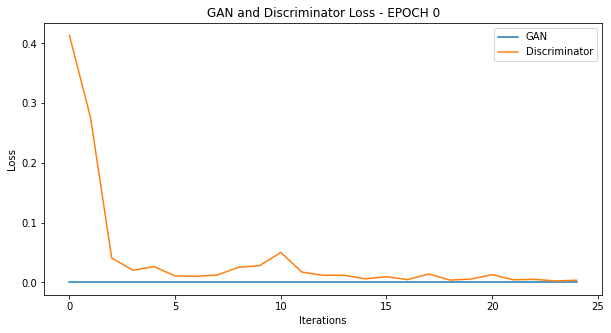

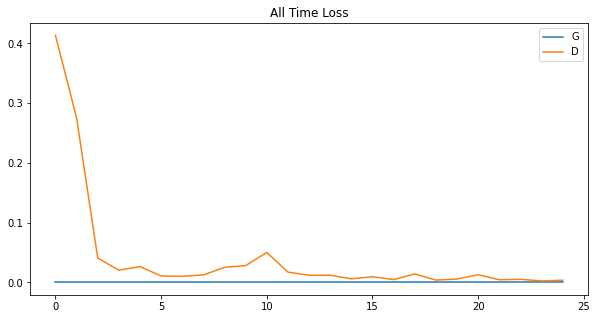

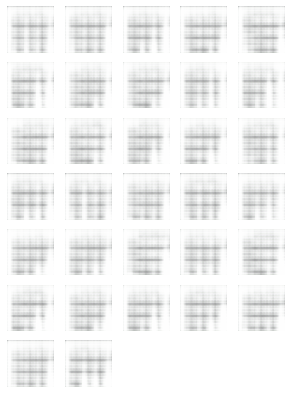

Epoch 2/10
GAN Loss Mean: 6.938734575052711e-06 Std: 1.908249366040989e-05
Discriminator Loss Mean: 0.0015256900404347106 Std: 0.0014606536684512775


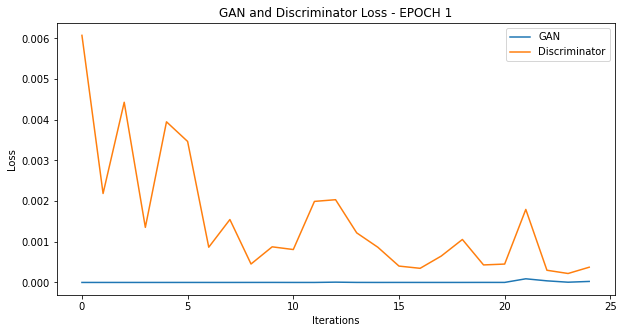

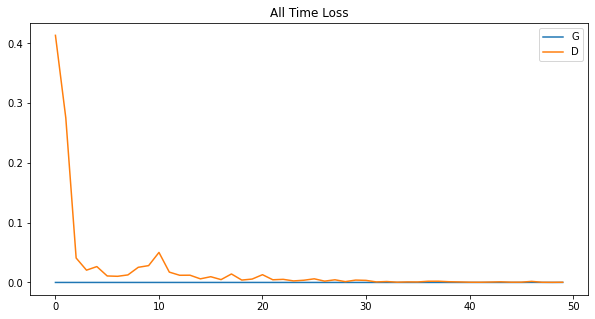

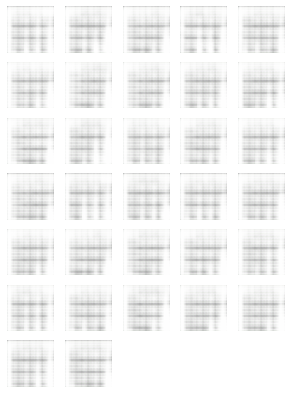

Epoch 3/10
GAN Loss Mean: 0.07018973643011123 Std: 0.3436042382359481
Discriminator Loss Mean: 0.14947128056461223 Std: 0.6424061578117782


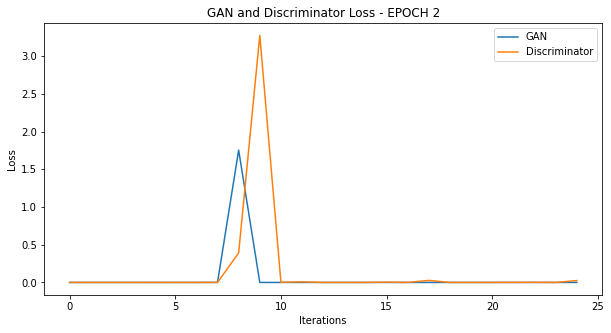

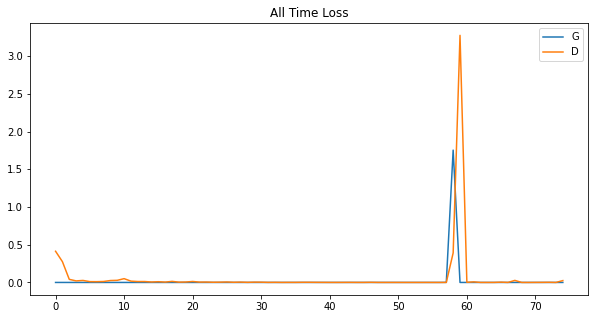

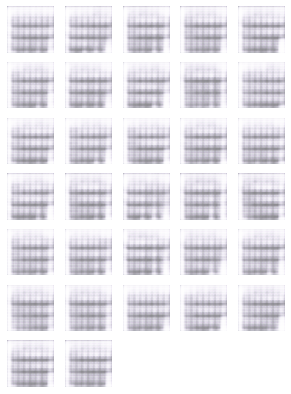

Epoch 4/10
GAN Loss Mean: 0.002441969180355059 Std: 0.01195321949608571
Discriminator Loss Mean: 0.005340214576717699 Std: 0.007725773157513761


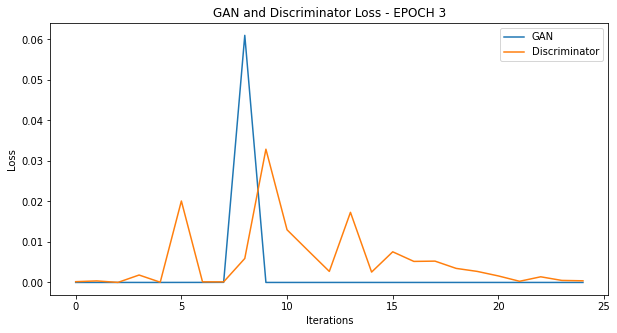

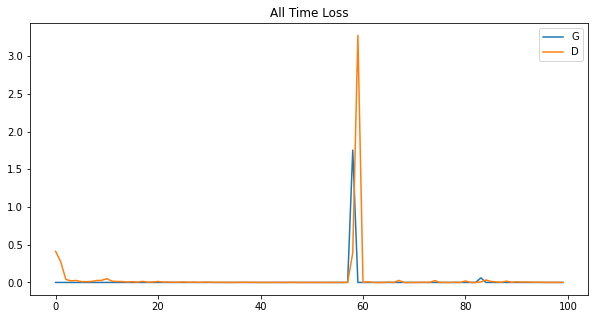

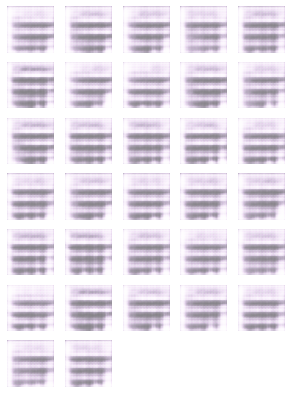

Epoch 5/10
GAN Loss Mean: 3.418180003741611e-05 Std: 6.427538354961522e-05
Discriminator Loss Mean: 0.0004036586286383681 Std: 0.0004069735049220613


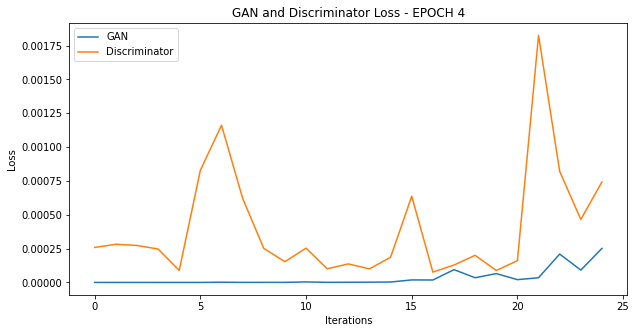

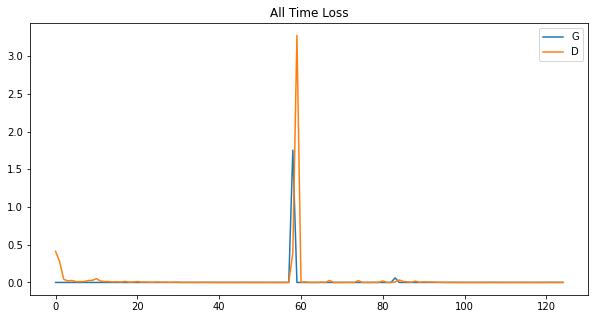

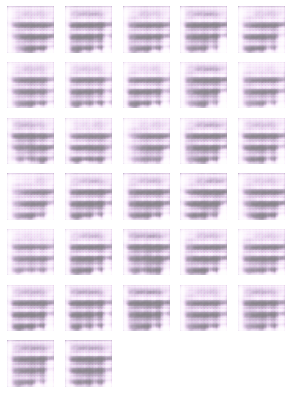

Epoch 6/10


KeyboardInterrupt: ignored

In [72]:
train_gan(gan, dataset, BATCH_SIZE, CODINGS_SIZE, n_epochs=10, smooth_and_noise=False)